In [24]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go

from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = pd.read_csv('GPU_sales.csv')

# Testing for Multicollinearity

## Calculating the VIF

We first investigate how much variance of the estimated regression coefficient is inflated if the independent variables are correlated.

Interpreting VIF:
- VIF = 1 independent variables are not correlated
- 1 < VIF < 5 variables are moderately correlated
- 5 <= VIF <= 10 highly correlated
- 10 < VIF regression coefficients are "feebly estimated with the presence of multicollinearity"

Note: Our independent variables in this dataframe is Wattage, VRAM and 3DMARK.

Result: Most of the values have a high VIF 

Interpretation: There is potentially multicollinearity present

In [25]:
X = df[['Wattage', 'VRAM', '3DMARK', 'Retail Price', 'Used Price']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

        feature        VIF
0       Wattage  23.813981
1          VRAM  21.203587
2        3DMARK  35.627980
3  Retail Price   8.528871
4    Used Price  11.849609


In [26]:
X = df[['Wattage', 'VRAM', '3DMARK', 'Retail Price', 'Used Price']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

print(vif_data)

        feature
0       Wattage
1          VRAM
2        3DMARK
3  Retail Price
4    Used Price


## Calculating Tolerance

In [27]:
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

tolerance = 1 / vif_data["VIF"]

print(tolerance)

0    0.041992
1    0.047162
2    0.028068
3    0.117249
4    0.084391
Name: VIF, dtype: float64


## Calculating Eigenvalues

Our second method for detecting multicollinearity.

If one or more eigenvalues are close to zero and the condition number is large then multicollinearity is present.

Dataframe 4 is a copy of Dataframe 3 just with the Names of the GPUs dropped so the calculation can work.

In [28]:
df.copy()

df1 = df.copy()

df1 = df1.drop('Name', axis=1)

df1 = df1.drop('Date', axis=1)

df1.head()

,Wattage,VRAM,3DMARK,Retail Price,Used Price,Year,Month
0,75,2,1861,0,0,2024,1
1,75,2,1861,0,0,2024,2
2,75,2,1861,192,61,2023,3
3,75,2,1861,254,52,2024,3
4,75,2,1861,181,55,2023,4


In [29]:
# Calculate the correlation matrix
correlation_matrix = df1.corr()

# Calculate eigenvalues
eigenvalues = np.linalg.eigvals(correlation_matrix)
eigenvalues

array([4.38605851, 1.20243506, 0.80157619, 0.05222675, 0.1290738 ,
       0.18543885, 0.24319084])

## Calculating the condition index

The condition index shows the degree of multicollinearity present in the independent variables.

A value between 5 and 10 = a weak correlation.

A value greater than 30 = strong correlation.

In [30]:
# Calculate the correlation matrix
correlation_matrix = df1.corr()

# Calculate eigenvalues
eigenvalues = np.linalg.eigvals(correlation_matrix)

# Calculate the condition index
condition_index = np.sqrt(max(eigenvalues) / eigenvalues)
print(f"Condition Index: {condition_index}")

Condition Index: [1.         1.90988138 2.33918627 9.16411903 5.82932346 4.86336475
 4.24681755]


## Is there Multicollinearity present in this dataset?

In total, we used 4 different ways to test if multicollinearity is present:

Correlation matrix
Variance Inflation Factor (VIF)
Eigenvalue
Condition index
Results:

All variables had strong correlations with each other
All of the independent variables had a strong VIF
All the Eigenvalues of the variables were close to 0
The condition index shows weak correlation
Conclusion? Multicollinearity is present in this dataset since 3 out of 4 tests indicates it's presence.

# Testing Normality

I am going to use only the Shapiro-Wilk Test to test for normality and use a Hard Fail rule, where if this dataset fails this test it is declared to be NOT normal.

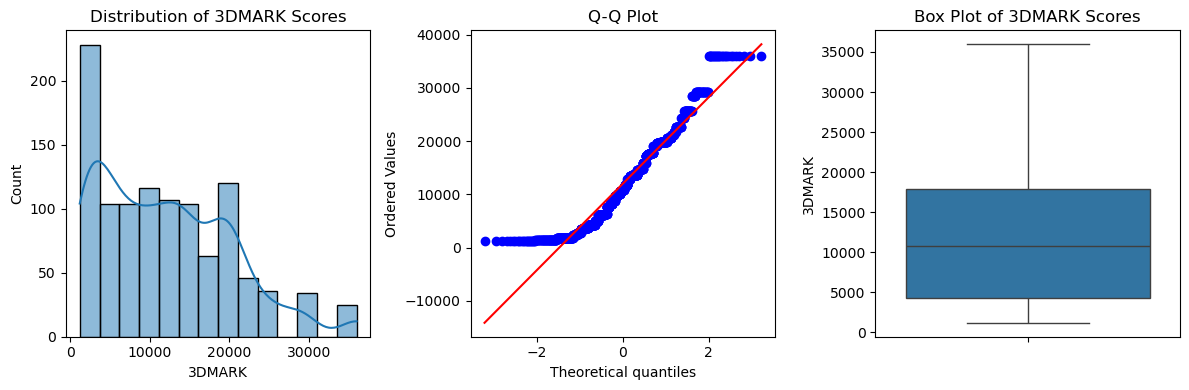

In [31]:
#Histogram
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(df['3DMARK'], kde=True)
plt.title('Distribution of 3DMARK Scores')

# Q-Q plot
plt.subplot(1, 3, 2)
stats.probplot(df['3DMARK'], dist="norm", plot=plt)
plt.title('Q-Q Plot')

# Box plot
plt.subplot(1, 3, 3)
sns.boxplot(y=df['3DMARK'])
plt.title('Box Plot of 3DMARK Scores')
plt.tight_layout()
plt.show()

In [32]:
# Shapiro-Wilk Test
shapiro_stat, shapiro_p = stats.shapiro(df['3DMARK'])
print(f'Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}')
if shapiro_p > 0.05:
    print("Data is normally distributed (fail to reject H0)")
else:
    print("Data is NOT normally distributed (reject H0)")

Shapiro-Wilk Test: Statistic=0.9366, p-value=0.0000
Data is NOT normally distributed (reject H0)


In [33]:
# Calculate skewness and kurtosis
skewness = df['3DMARK'].skew()
kurtosis = df['3DMARK'].kurtosis()

print(f'Skewness: {skewness:.4f}')
print(f'Kurtosis: {kurtosis:.4f}')

# Interpretation
if abs(skewness) < 0.5:
    print("Approximately symmetric")
elif abs(skewness) < 1:
    print("Moderately skewed")
else:
    print("Highly skewed")

if abs(kurtosis) < 3:
    print("Approximately mesokurtic (normal tails)")
elif kurtosis > 3:
    print("Leptokurtic (heavy tails)")
else:
    print("Platykurtic (light tails)")

Skewness: 0.6837
Kurtosis: -0.0418
Moderately skewed
Approximately mesokurtic (normal tails)


## Testing normality of VRAM

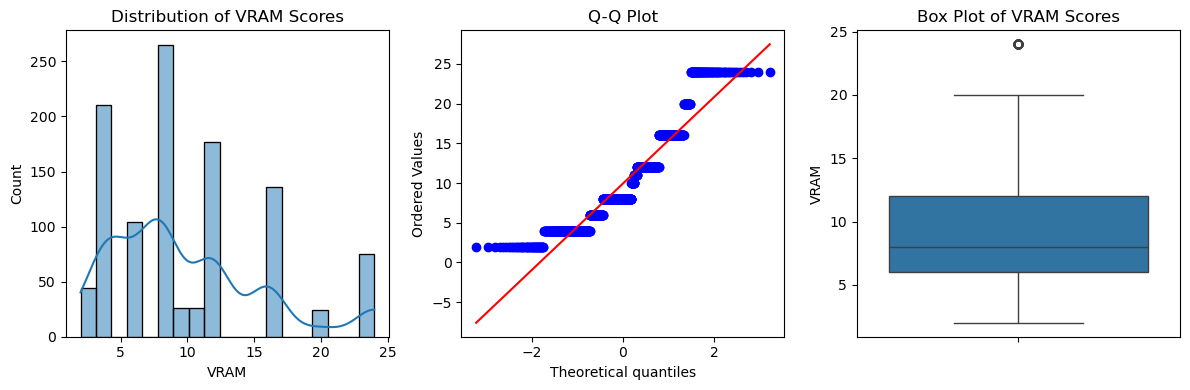

In [34]:
#Histogram
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(df['VRAM'], kde=True)
plt.title('Distribution of VRAM Scores')

# Q-Q plot
plt.subplot(1, 3, 2)
stats.probplot(df['VRAM'], dist="norm", plot=plt)
plt.title('Q-Q Plot')

# Box plot
plt.subplot(1, 3, 3)
sns.boxplot(y=df['VRAM'])
plt.title('Box Plot of VRAM Scores')
plt.tight_layout()
plt.show()

In [35]:
# Shapiro-Wilk Test
shapiro_stat, shapiro_p = stats.shapiro(df['VRAM'])
print(f'Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}')
if shapiro_p > 0.05:
    print("Data is normally distributed (fail to reject H0)")
else:
    print("Data is NOT normally distributed (reject H0)")

Shapiro-Wilk Test: Statistic=0.8916, p-value=0.0000
Data is NOT normally distributed (reject H0)


In [36]:
# Calculate skewness and kurtosis
skewness = df['VRAM'].skew()
kurtosis = df['VRAM'].kurtosis()

print(f'Skewness: {skewness:.4f}')
print(f'Kurtosis: {kurtosis:.4f}')

# Interpretation
if abs(skewness) < 0.5:
    print("Approximately symmetric")
elif abs(skewness) < 1:
    print("Moderately skewed")
else:
    print("Highly skewed")

if abs(kurtosis) < 3:
    print("Approximately mesokurtic (normal tails)")
elif kurtosis > 3:
    print("Leptokurtic (heavy tails)")
else:
    print("Platykurtic (light tails)")

Skewness: 0.9303
Kurtosis: 0.2532
Moderately skewed
Approximately mesokurtic (normal tails)


## Retail Price

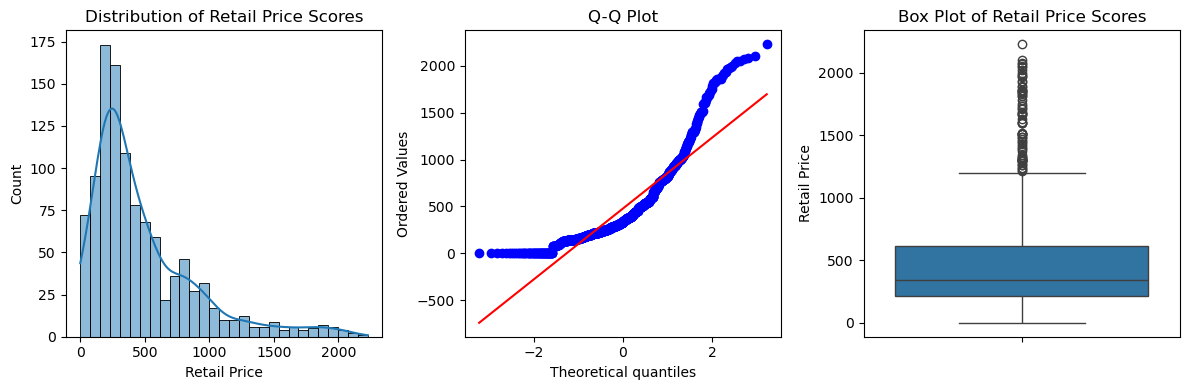

In [46]:
#Histogram
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(df['Retail Price'], kde=True)
plt.title('Distribution of Retail Price Scores')

# Q-Q plot
plt.subplot(1, 3, 2)
stats.probplot(df['Retail Price'], dist="norm", plot=plt)
plt.title('Q-Q Plot')

# Box plot
plt.subplot(1, 3, 3)
sns.boxplot(y=df['Retail Price'])
plt.title('Box Plot of Retail Price Scores')
plt.tight_layout()
plt.show()

In [38]:
# Shapiro-Wilk Test
shapiro_stat, shapiro_p = stats.shapiro(df['Retail Price'])
print(f'Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}')
if shapiro_p > 0.05:
    print("Data is normally distributed (fail to reject H0)")
else:
    print("Data is NOT normally distributed (reject H0)")

Shapiro-Wilk Test: Statistic=0.8346, p-value=0.0000
Data is NOT normally distributed (reject H0)


In [39]:
# Calculate skewness and kurtosis
skewness = df['Retail Price'].skew()
kurtosis = df['Retail Price'].kurtosis()

print(f'Skewness: {skewness:.4f}')
print(f'Kurtosis: {kurtosis:.4f}')

# Interpretation
if abs(skewness) < 0.5:
    print("Approximately symmetric")
elif abs(skewness) < 1:
    print("Moderately skewed")
else:
    print("Highly skewed")

if abs(kurtosis) < 3:
    print("Approximately mesokurtic (normal tails)")
elif kurtosis > 3:
    print("Leptokurtic (heavy tails)")
else:
    print("Platykurtic (light tails)")

Skewness: 1.6719
Kurtosis: 2.8833
Highly skewed
Approximately mesokurtic (normal tails)


## Used Price

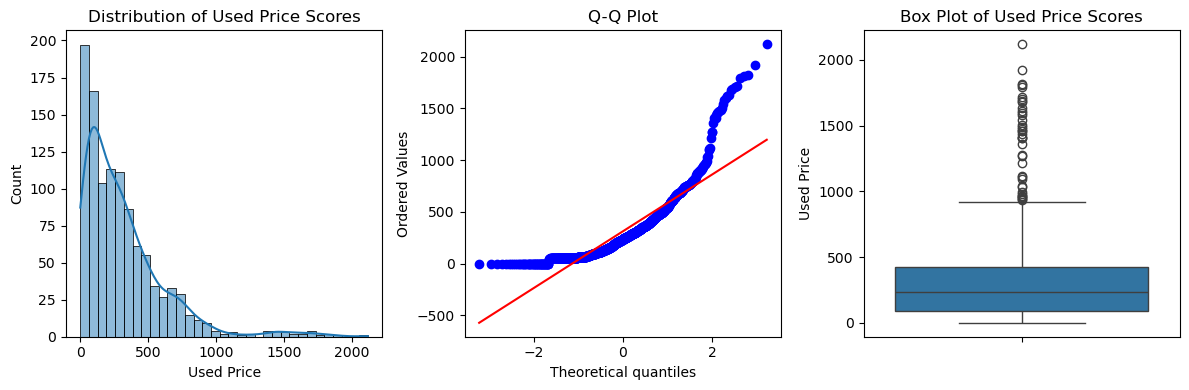

In [40]:
#Histogram
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(df['Used Price'], kde=True)
plt.title('Distribution of Used Price Scores')

# Q-Q plot
plt.subplot(1, 3, 2)
stats.probplot(df['Used Price'], dist="norm", plot=plt)
plt.title('Q-Q Plot')

# Box plot
plt.subplot(1, 3, 3)
sns.boxplot(y=df['Used Price'])
plt.title('Box Plot of Used Price Scores')
plt.tight_layout()
plt.show()

In [41]:
# Shapiro-Wilk Test
shapiro_stat, shapiro_p = stats.shapiro(df['Used Price'])
print(f'Shapiro-Wilk Test: Statistic={shapiro_stat:.4f}, p-value={shapiro_p:.4f}')
if shapiro_p > 0.05:
    print("Data is normally distributed (fail to reject H0)")
else:
    print("Data is NOT normally distributed (reject H0)")

Shapiro-Wilk Test: Statistic=0.8013, p-value=0.0000
Data is NOT normally distributed (reject H0)


In [42]:
# Calculate skewness and kurtosis
skewness = df['Used Price'].skew()
kurtosis = df['Used Price'].kurtosis()

print(f'Skewness: {skewness:.4f}')
print(f'Kurtosis: {kurtosis:.4f}')

# Interpretation
if abs(skewness) < 0.5:
    print("Approximately symmetric")
elif abs(skewness) < 1:
    print("Moderately skewed")
else:
    print("Highly skewed")

if abs(kurtosis) < 3:
    print("Approximately mesokurtic (normal tails)")
elif kurtosis > 3:
    print("Leptokurtic (heavy tails)")
else:
    print("Platykurtic (light tails)")

Skewness: 2.1399
Kurtosis: 6.3511
Highly skewed
Leptokurtic (heavy tails)
